In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
!unzip /content/drive/MyDrive/complaints.csv.zip

Archive:  /content/drive/MyDrive/complaints.csv.zip
  inflating: complaints.csv          


In [7]:
# Load the dataset
data = "/content/complaints.csv"
df = pd.read_csv(data)

<ipython-input-7-469162259>:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data)


In [8]:
# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

# Let's focus on the relevant columns
df = df[['Product', 'Consumer complaint narrative']].copy()
df = df.rename(columns={'Consumer complaint narrative': 'Complaint', 'Product': 'Product'})

# Check missing values
print("\nMissing values after selection:")
print(df.isnull().sum())

# Drop rows with missing complaints
df = df.dropna(subset=['Complaint'])

# Clean the Product column
print("\nOriginal product categories:")
print(df['Product'].value_counts())

# Map to our 4 categories
product_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': '0',
    'Credit reporting': '0',
    'Credit card': '2',
    'Payday loan': '2',
    'Money transfers': '2',
    'Student loan': '2',
    'Bank account or service': '2',
    'Consumer Loan': '2',
    'Prepaid card': '2',
    'Other financial service': '2',
    'Virtual currency': '2',
    'Debt collection': '1',
    'Mortgage': '3'
}

# Apply mapping and drop unmapped categories
df['Product'] = df['Product'].map(product_mapping)
df = df.dropna(subset=['Product'])

# Convert to integer type
df['Product'] = df['Product'].astype(int)

# Check the distribution
print("\nMapped product distribution:")
print(df['Product'].value_counts())


Dataset shape: (9420854, 18)

Columns in the dataset:
['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

Missing values per column:
Date received                         0
Product                               0
Sub-product                      235295
Issue                                 6
Sub-issue                        837306
Consumer complaint narrative    6482799
Company public response         4675402
Company                               0
State                             54292
ZIP code                          30228
Tags                            8797038
Consumer consent provided?      1622090
Submitted via                         0
Date sent to company                  0
Company response to consumer    

**DATA** **VISUALIZATION**


Distribution of Complaint Categories:


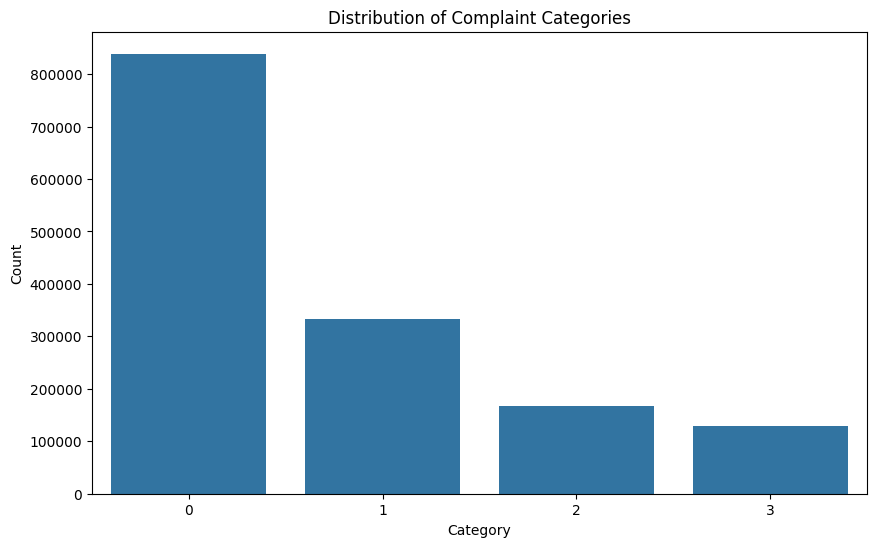

In [9]:
print("\nDistribution of Complaint Categories:")
# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Product', data=df)
plt.title('Distribution of Complaint Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()



Complaint length statistics:
count    1.468547e+06
mean     9.959658e+02
std      1.266002e+03
min      4.000000e+00
25%      3.400000e+02
50%      6.460000e+02
75%      1.180000e+03
max      3.278500e+04
Name: Complaint_length, dtype: float64

Distribution of Complaint Lengths:


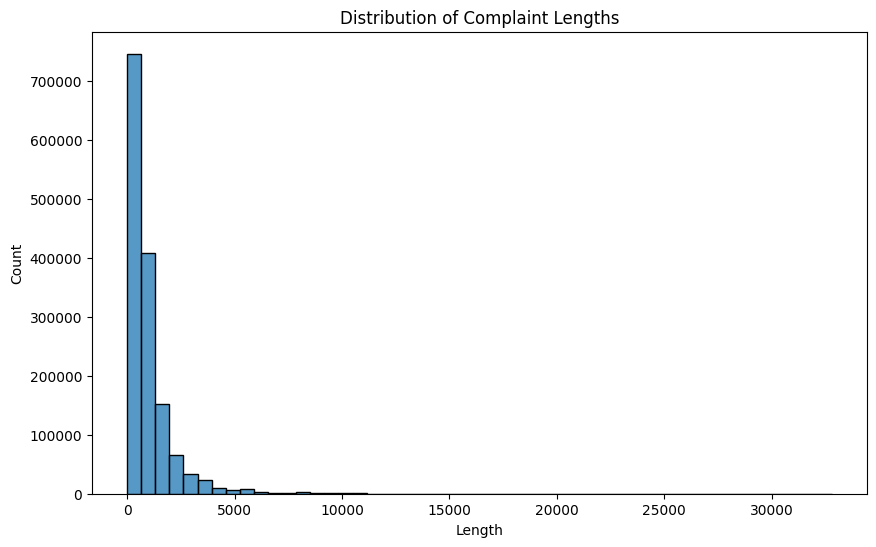


Complaint Length by Categories:


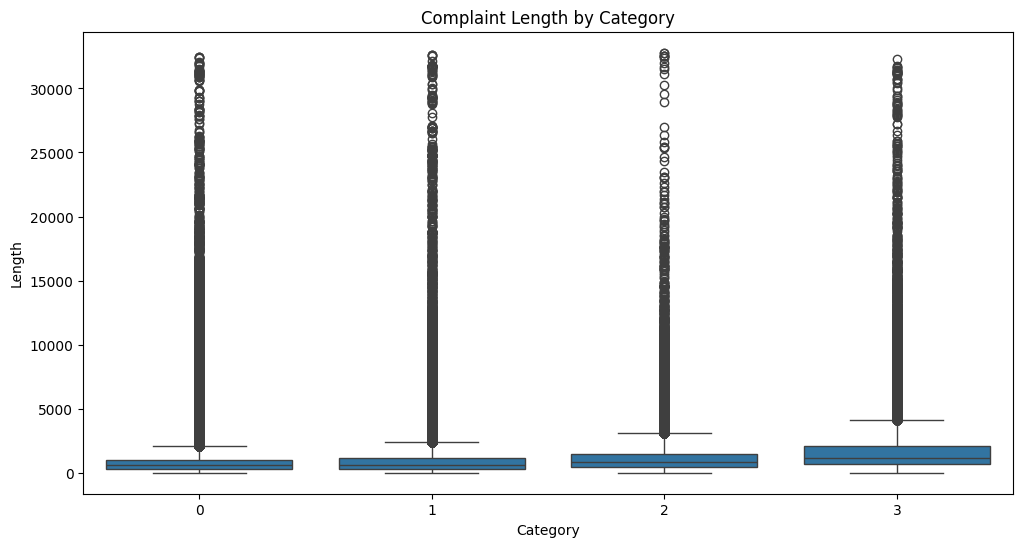

In [10]:
# Check complaint length
df['Complaint_length'] = df['Complaint'].apply(len)
print("\nComplaint length statistics:")
print(df['Complaint_length'].describe())

print("\nDistribution of Complaint Lengths:")
# Plot complaint length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Complaint_length'], bins=50)
plt.title('Distribution of Complaint Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

print("\nComplaint Length by Categories:")
# Plot complaint length by category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product', y='Complaint_length', data=df)
plt.title('Complaint Length by Category')
plt.xlabel('Category')
plt.ylabel('Length')
plt.show()

# **TEXT** **PREPROCESSING**

In [11]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Tokenize
    tokens = text.split()

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Rejoin tokens
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Apply cleaning to complaints
df['Cleaned_complaint'] = df['Complaint'].apply(clean_text)

# Check the cleaned text
print("\nOriginal complaint example:")
print(df['Complaint'].iloc[0])
print("\nCleaned complaint example:")
print(df['Cleaned_complaint'].iloc[0])

# Split into training and test sets
X = df['Cleaned_complaint']
y = df['Product']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Original complaint example:
I purchased a home from Illinois to move to Louisiana via a realtor XXXX XXXX XXXX. I was set up with NewsRez Mortgage. I originally setup to send in my payment, but switched over to automatically for withdrawal in 2020. The first year after paying my mortgage NewRez faile to pay my property tax on time. This caused an emotional stress and embarrassment of having a Sheriff to place a notice on my front door of being in default of paying my property tax. Then in XXXX NewRez failed to pay my homeowners insurance on time which had XXXX insurance to close my account. I attempt plead with them that it wasnt my fault. NewRez failed to withdraw the money from my escrow account which was on file. NewsRez forced me into some ridiculous insure they were applying on my automatic withdrawal. My mortgage went from under & XXXX {$1900.00} a month to {$3300.00} a month. They havent operated in good faith. It seems they were in cahoots with Louisiana insurance to charge co

# **FEATURE EXTRACTION**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.7
)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf.transform(X_test)

# Check shape
print(f"\nTF-IDF training shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape: {X_test_tfidf.shape}")

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


TF-IDF training shape: (1174837, 5000)
TF-IDF test shape: (293710, 5000)


# **MODEL SELECTION AND TRAINING**

In [27]:
# Define models to evaluate
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_res, y_train_res)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

ValueError: could not convert string to float: 'xxxx xxxx received email company called chime relationship indicated card mailed never relationship company open account impossible get someone line allow account closed without phone call someone used actual information including social security number phone number yearsold address open account refused close account unless provided verifying information problem elaborate phishing attempt looking xxxx happened thousand people account company opened name without knowledge using actual information'

# **MODEL COMPARISON**

In [ ]:
# Compare model performance
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[x]['accuracy'] for x in results]
}).sort_values('Accuracy', ascending=False)

print("\nModel Comparison:")
print(model_comparison)

# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=model_comparison, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0.7, 1.0)
plt.show()

# Select best model
best_model_name = model_comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest model: {best_model_name}")

# Detailed evaluation of best model
print("\nBest model detailed evaluation:")
print(results[best_model_name]['report'])

# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
sns.heatmap(results[best_model_name]['confusion_matrix'],
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3'],
            yticklabels=['0', '1', '2', '3'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **MODEL EVALUATION**

In [ ]:
# Create final pipeline with best parameters
final_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.7
    )),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        C=10,
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ))
])

# Train on the entire training set
final_pipeline.fit(X_train, y_train)

# Evaluate on test set
y_pred = final_pipeline.predict(X_test)
print("\nFinal Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3'],
            yticklabels=['0', '1', '2', '3'])
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **PREDICTION**

In [ ]:
# Example new complaints
new_complaints = [
    "I've been receiving calls from a debt collector about a credit card debt I don't recognize.",
    "There's an error on my credit report showing a late payment that I know I made on time.",
    "The mortgage company charged me unexpected fees at closing that weren't disclosed upfront.",
    "My auto loan application was denied without proper explanation."
]

# Clean the new complaints
cleaned_new = [clean_text(complaint) for complaint in new_complaints]

# Make predictions
predictions = final_pipeline.predict(cleaned_new)
prediction_probs = final_pipeline.predict_proba(cleaned_new)

# Map category numbers to names
category_names = {
    0: 'Credit reporting, repair, or other',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

# Display predictions
print("\nPredictions for new complaints:")
for i, (complaint, pred) in enumerate(zip(new_complaints, predictions)):
    print(f"\nComplaint {i+1}:")
    print(f"Text: {complaint}")
    print(f"Predicted category: {category_names[pred]} (Category {pred})")
    print("Prediction probabilities:")
    for j, prob in enumerate(prediction_probs[i]):
        print(f"  {category_names[j]}: {prob:.4f}")